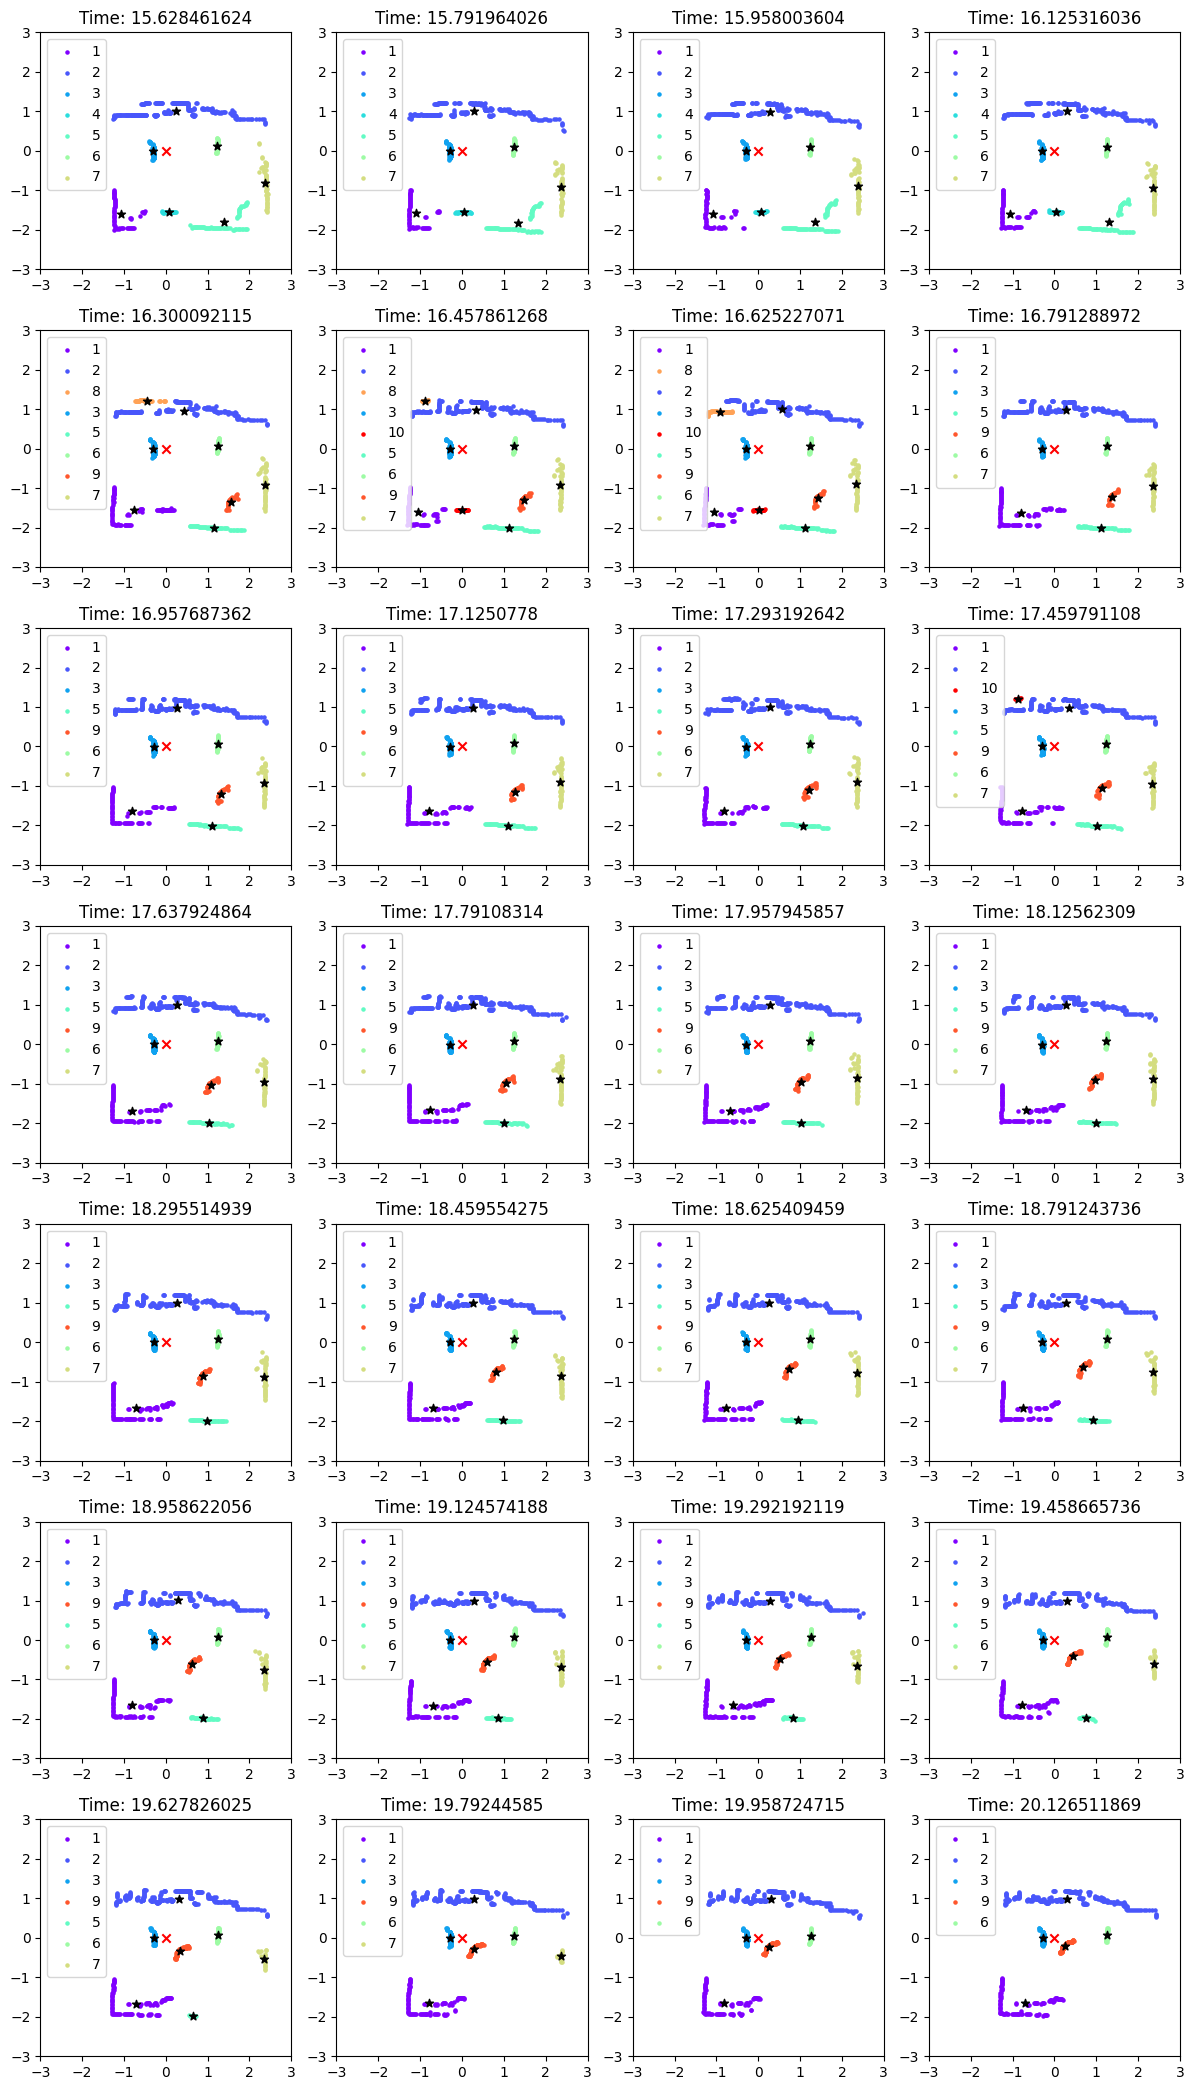

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import numpy as np

COMPONENT_SIZE = 30
COMPONENT_THRESH = 5
MAX_RANGE = 3
NUM_ITERATIONS = 6
MAX_DISPLACEMENT = 3
MAX_SEGMENTS = 10
RAW_DATA = open('cleaned.txt', 'r').readlines()[84:112]

figure, axis = plt.subplots(len(RAW_DATA)//4, 4, figsize=(12, 21))
color_options = cm.rainbow(np.linspace(0, 1, MAX_SEGMENTS))
segments = []
subplot = 0
for frame in range(len(RAW_DATA)):
    stripped = RAW_DATA[frame].replace('\n', ' ').replace('(', ' ').replace(')', ' ').replace('[', ' ').replace(']', ' ').replace(':', ',').replace(' ', '').split(',')[2:]
    points = [[float(stripped[2 * i]), float(stripped[2 * i + 1])] for i in range(int(len(stripped)/2)) if abs(float(stripped[2 * i])) < MAX_RANGE and abs(float(stripped[2 * i + 1])) < MAX_RANGE]
    segments.append([float(RAW_DATA[frame].replace(' ', ',').split(',')[1])])
    segments[frame].append([0, 0, 0, [], []])
    components = []
    label = 1
    grid = [[0 for i in range(COMPONENT_SIZE)] for j in range(COMPONENT_SIZE)]
    for i in points:
        a, b = [int(math.floor(j / ((2 * MAX_RANGE)/COMPONENT_SIZE)) + COMPONENT_SIZE/2) for j in i]
        grid[a][b] -= 1
        if grid[a][b] == -COMPONENT_THRESH:
            components.append((a, b))
    components.sort()
    for (a, b) in components:
        if grid[a][b] >= 0:
            continue
        neighbors = [(a, b)]
        index = 0
        while index < len(neighbors):
            (i, j) = neighbors[index]
            index += 1
            if grid[i][j] >= 0:
                continue
            neighbors.extend([(i - 1, j)] if i > 0 and grid[i - 1][j] <= 0 else [])
            neighbors.extend([(i - 1, j - 1)] if i > 0 and j > 0 and grid[i - 1][j - 1] <= 0 else [])
            neighbors.extend([(i - 1, j + 1)] if i > 0 and j < COMPONENT_SIZE - 1 and grid[i - 1][j + 1] <= 0 else [])
            neighbors.extend([(i, j + 1)] if j < COMPONENT_SIZE - 1 and grid[i][j + 1] <= 0 else [])
            neighbors.extend([(i, j - 1)] if j > 0 and grid[i][j - 1] <= 0 else [])
            neighbors.extend([(i + 1, j)] if i < COMPONENT_SIZE - 1 and grid[i + 1][j] <= 0 else [])
            neighbors.extend([(i + 1, j - 1)] if i < COMPONENT_SIZE - 1 and j > 0 and grid[i + 1][j-1] <= 0 else [])
            neighbors.extend([(i + 1, j + 1)] if i < COMPONENT_SIZE - 1 and j < COMPONENT_SIZE - 1 and grid[i + 1][j + 1] <= 0 else [])
            grid[i][j] = label
        segments[frame].append([label, 0, 0, [], []])
        label += 1
    for i in points:
        a, b = [int(math.floor(j / ((2 * MAX_RANGE)/COMPONENT_SIZE)) + COMPONENT_SIZE/2) for j in i]
        segments[frame][max(grid[a][b], 0) + 1][3].append(i[0])
        segments[frame][max(grid[a][b], 0) + 1][4].append(i[1])
    for i in range(2, len(segments[frame])):
        segments[frame][i][1], segments[frame][i][2] = [sum(j)/len(j) for j in segments[frame][i][3:]]
    old, new = [[(i[1], i[2], i[0]) for i in segments[j][2:]] for j in range(frame - 1, frame + 1)]
    for i in range(NUM_ITERATIONS):
        for j in old:
            for k in new:
                if (k[0] - j[0])**2 + (k[1] - j[1])**2 <= (MAX_DISPLACEMENT * (2 * MAX_RANGE)/COMPONENT_SIZE * i/NUM_ITERATIONS)**2:
                    old.remove(j)
                    new.remove(k)
                    segments[frame][k[2] + 1][0] = j[2]
                    break
    new_max = max([j[0] for j in segments[frame - 1][2:]]) + 1
    for i in new:
        segments[frame][i[2] + 1][0] = new_max
        new_max += 1
    axis[subplot//4, subplot % 4].scatter(segments[frame][1][3], segments[frame][1][4],color="white")
    for i in range(2, len(segments[frame])):
        axis[subplot//4, subplot % 4].scatter(segments[frame][i][3], segments[frame][i][4], color = color_options[segments[frame][i][0] - 1], s=5,label=segments[frame][i][0])
        axis[subplot//4, subplot % 4].scatter(segments[frame][i][1], segments[frame][i][2], c="black", marker='*')
    axis[subplot//4, subplot % 4].scatter(0, 0, c="red", marker='x')
    axis[subplot//4, subplot % 4].set_xlim(-MAX_RANGE, MAX_RANGE)
    axis[subplot//4, subplot % 4].set_ylim(-MAX_RANGE, MAX_RANGE)
    axis[subplot//4, subplot % 4].set_title("Time: " + str(segments[frame][0]))
    axis[subplot//4, subplot % 4].legend()
    subplot += 1

plt.tight_layout()
plt.savefig('online_segmentation.png')
plt.show()